# Predictive modeling of `SalePrice` in Ames housing dataset

In a previous notebook we [processed and cleaned](process.ipynb/#Processing-the-Ames-housing-dataset) the Ames dataset, and in another we [explored the data and selected/engineered some new features](explore.ipynb/#Exploratory-analysis-of-Ames-housing-dataset).

In this notebook, we'll model and predict `SalePrice`. First we'll do a little feature selection and engineering to create a few different versions of the data for modeling. Then we'll compare the prediction performance of some appropriate models on these versions, select a subset of these versions and models for fine-tuning, ensemble them to maximize predictive generalizablity, and test them by submitting to Kaggle.

## Setup

In [1]:
%matplotlib inline
import warnings
import os
import sys
import time
import hyperopt.hp as hp

from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from hyperopt.pyll import scope as ho_scope

# add parent directory for importing custom classes
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(pardir)

# custom classes and helpers
from codes.process import DataDescription, HPDataFramePlus, DataPlus
from codes.explore import load_datasets, plot_cont_dists
from codes.model import *

warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')
sns.set_style('white')

## Load and prepare data

In [2]:
hp_data = load_datasets(data_dir='../data', file_names=['clean.csv'])
clean = hp_data.dfs['clean']

The dataset `clean` was ([created in a previous notebook](process.ipynb/#Processing-and-cleaning-the-Ames-housing-dataset). It is the original dataset with someproblematic variables and observations dropped and missing values imputed. We'll use it to create our modeling data

## Feature selection and engineering

We'll use the results of [our exploratory analysis](explore.ipynb/#Exploratory-analysis-of-Ames-housing-dataset) to suggest variables that can be altered, combined, or eliminated in the hopes of improving predictive models. We'll create a few new datasets in the process. In the end we'll have four versions of the data for modeling

- `clean`: original dataset with problematic features and observations dropped and missing values imputed.
- `drop`: `clean` dataset with some old features dropped
- `clean_edit`: `clean` dataset with some feature values combined and some new features added
- `drop_edit`: `drop` dataset with the same feature values combined and same new features added.

### Drop some features

Here are variables we'll drop (and the reasons for dropping):
- `Heating`, `RoofMatl`, `Condition2`, `Street` (extremely unbalanced distributions and very low dependence with `SalePrice` ($D \gtrapprox 0.99$))
- `Exterior2nd` (redundant with `Exterior1st`.
- `HouseStyle` (redundant with `MSSubclass`).
- `Utilities` (extremely unbalanced distribution and very low dependence with response)
- `PoolQC` (extremely unbalanced distribution and redundant with `PoolArea`)
- `1stFlrSF` and `TotalBsmtSF` (high dependence with `GrLivArea`).
- `GarageYrBlt` (high dependence with `YearBuilt`)
- `PoolArea`, `MiscVal`, `3SsnPorch`, `ScreenPorch`, `BsmtFinSF2` (extremely peaked distributions and very low dependence with `SalePrice`)
- `LowQualFinSF` (extremely peaked distribution and redundant with ordinal quality measures such as `OverallQual`)

In [3]:
drop_cols = ['Heating', 'RoofMatl', 'Condition2', 'Street', 'Exterior2nd', 'HouseStyle', 
             'Utilities', 'PoolQC', '1stFlrSF', 'TotalBsmtSF', 'GarageYrBlt', 'PoolArea', 'MiscVal',
             '3SsnPorch', 'ScreenPorch', 'BsmtFinSF2', 'LowQualFinSF']
drop = HPDataFramePlus(data=clean.data)
drop.data = drop.data.drop(columns=drop_cols)

In [4]:
drop.data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'Exterior1st', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtUnfSF', 'HeatingQC',
       'CentralAir', 'Electrical', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'Fence', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

### Combine values and create new variables

Some discrete variables had very small counts for some values (this could be seen as horizontal lines corresponding to those values in the violin plots for [categorical](#Relationship-between-categoricals-and-SalePrice) and [ordinal](#Relationship-between-ordinals-and-SalePrice) variables. 

First we'll look at categorical variables

In [5]:
cats_data = clean.data.select_dtypes('category')
cats_data.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'LandContour', 'LotConfig',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [6]:
# print variables with less than 5 observations for any value
small_val_count_cat_cols = print_small_val_counts(data=cats_data, val_count_threshold=6)


20     1078
60      573
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

Norm      2887
Feedr       13
Artery       5
PosA         4
PosN         3
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

Gable      2310
Hip         549
Gambrel      22
Flat         19
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64

CompShg    2875
Tar&Grv      22
WdShake       9
WdShngl       7
Roll          1
Metal         1
Membran       1
Name: RoofMatl, dtype: int64

VinylSd    1026
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     220
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
Stone         2
CBlock        2
AsphShn       2
ImStucc       1
Name: Exterior1st, dtype: int64

VinylSd    1015
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     269
C

In [7]:
desc = DataDescription('../data/data_description.txt')
clean.desc = desc
clean.print_desc(small_val_count_cat_cols)

MSSubClass: Identifies the type of dwelling involved in the sale.

	 20 - 1-STORY 1946 & NEWER ALL STYLES
	 30 - 1-STORY 1945 & OLDER
	 40 - 1-STORY W/FINISHED ATTIC ALL AGES
	 45 - 1-1/2 STORY - UNFINISHED ALL AGES
	 50 - 1-1/2 STORY FINISHED ALL AGES
	 60 - 2-STORY 1946 & NEWER
	 70 - 2-STORY 1945 & OLDER
	 75 - 2-1/2 STORY ALL AGES
	 80 - SPLIT OR MULTI-LEVEL
	 85 - SPLIT FOYER
	 90 - DUPLEX - ALL STYLES AND AGES
	 120 - 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
	 150 - 1-1/2 STORY PUD - ALL AGES
	 160 - 2-STORY PUD - 1946 & NEWER
	 180 - PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
	 190 - 2 FAMILY CONVERSION - ALL STYLES AND AGES


Condition2: Proximity to various conditions (if more than one is present)

	 Artery - Adjacent to arterial street
	 Feedr - Adjacent to feeder street
	 Norm - Normal
	 RRNn - Within 200' of North-South Railroad
	 RRAn - Adjacent to North-South Railroad
	 PosN - Near positive off-site feature--park, greenbelt, etc.
	 PosA - Adjacent to postive off

We'll perform the following combinations of categorical variable values:

- `MSSubClass`: Change the single observation with value 150 to 50, the next most sensible value 

- `Condition2`: Merge `PosA`, `PosN`, `RRNn`, `RRAn`, and `RRAe` into a new value `Other`
- `RoofMatl`: Merge `WdShake`, `WdShingle` into a new value `Wood` and `Roll`, `Metal`, `Membran` into a new value `Other`
- `Exterior1st`, : Merge `BrkComm` into `BrkFace`, `AsphShn` into `AsbShng`, `ImStucc` into `Stucco` and  `Stone` and `CBlock` into a new value `Other`
-  `Exterior2nd`: Merge `AsphShn` into `AsbShng` and `Stone` and `CBlock` into `Other`
- `Heating`: Merge `Wall`, `OthW`, and `Floor` into a new variable `Other`

- `MasVnrType`: Merge `BrkComm` in `BrkFace`
- `Electrical`: Merge `FuseA`, `FuseF`, `FuseP`, and `Mix` into a new value `NonStd`

In [8]:
# new dataframes
clean_edit = HPDataFramePlus(data=clean.data)
drop_edit = HPDataFramePlus(data=drop.data)

# combine categorical variable values
clean_edit.data = combine_cat_vars(data=clean.data)
drop_edit.data = combine_cat_vars(data=drop.data)

Now we'll look at ordinal variables

In [9]:
# print small value counts of ordinal variables
edit_ords_data = clean.data.select_dtypes('int64')
small_val_count_ord_cols = print_small_val_counts(edit_ords_data, val_count_threshold=6)


3    2915
1       1
Name: Utilities, dtype: int64

5     825
6     731
7     600
8     342
4     225
9     107
3      40
10     29
2      13
1       4
Name: OverallQual, dtype: int64

3    2535
4     299
2      67
5      12
1       3
Name: ExterCond, dtype: int64

3    2603
4     122
2     104
0      82
1       5
Name: BsmtCond, dtype: int64

5    1490
3     857
4     474
2      92
1       3
Name: HeatingQC, dtype: int64

0    1707
1    1170
2      37
3       2
Name: BsmtFullBath, dtype: int64

0    2741
1     171
2       4
Name: BsmtHalfBath, dtype: int64

2    1529
1    1308
3      63
0      12
4       4
Name: FullBath, dtype: int64

3    1594
2     741
4     400
1     103
5      48
6      21
0       8
8       1
Name: BedroomAbvGr, dtype: int64

1    2782
2     129
0       3
3       2
Name: KitchenAbvGr, dtype: int64

2    1492
3    1150
4     203
1      70
0       1
Name: KitchenQual, dtype: int64

6     843
7     649
5     583
8     347
4     196
9     143
10     80
11     31
3   

In [10]:
clean.print_desc(small_val_count_ord_cols)

Utilities: Type of utilities available

	 AllPub - All public Utilities (E,G,W,& S)
	 NoSewr - Electricity, Gas, and Water (Septic Tank)
	 NoSeWa - Electricity and Gas Only
	 ELO - Electricity only


OverallQual: Rates the overall material and finish of the house

	 10 - Very Excellent
	 9 - Excellent
	 8 - Very Good
	 7 - Good
	 6 - Above Average
	 5 - Average
	 4 - Below Average
	 3 - Fair
	 2 - Poor
	 1 - Very Poor


ExterCond: Evaluates the present condition of the material on the exterior

	 Ex - Excellent
	 Gd - Good
	 TA - Average/Typical
	 Fa - Fair
	 Po - Poor


BsmtCond: Evaluates the general condition of the basement

	 Ex - Excellent
	 Gd - Good
	 TA - Typical - slight dampness allowed
	 Fa - Fair - dampness or some cracking or settling
	 Po - Poor - Severe cracking, settling, or wetness
	 NA - No Basement


HeatingQC: Heating quality and condition

	 Ex - Excellent
	 Gd - Good
	 TA - Average/Typical
	 Fa - Fair
	 Po - Poor


BsmtFullBath: Basement full bathrooms



BsmtHal

Even though many ordinal variables have values with low counts, we're less inclined to combine values because we lose ordering information. However we will drop `Utilities` from all data, since a binary variable with one observation for one value is essentially useless.

In [11]:
# drop extremely unbalanced binary variable
clean.data = clean.data.drop(columns=['Utilities'])
clean_edit.data = clean_edit.data.drop(columns=['Utilities'])

We'll also create some new variables:

- `Bath` = `HalfBath` + 2 * `FullBath` and drop
`HalfBath` and `FullBath`
- `BsmtBath` = `BsmtHalfBath` + 2 * `BsmtFullBath` and drop `BsmtHalfBath` and `BsmtFullBath`
- `AvgQual`, the average of `OverallQual`, `ExterQual`, `BsmtQual`, `HeatingQC`, `KitchenQual`, `FireplaceQu` and `GarageQual`.
- `AvgCond`, the average of `OverallCond`, `ExterCond`, `BsmtCond`, and `GarageCond`
- Indicator variables `HasBsmt`, `HasFireplace`, `HasPool`, `HasGarage`, `HasFence`

Note the factor of 2 in the new bath variables is so full baths are twice the weight of half baths. Also note the new average quality and condition variables will be quantitative (`float64` dtype)

In [12]:
# create new ordinal variables
clean_edit.data = create_ord_vars(clean_edit.data, clean.data)
drop_edit.data = create_ord_vars(drop_edit.data, clean.data)

Finally, we'll look at quantitative variables.

In [13]:
quants_data = clean.data.select_dtypes('float64')
quants_data.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'],
      dtype='object')

We [noted above](#Quantitative-variables) that many of these variables have high concentrations at zero. We'll

- Create indicator variables `Has2ndFlr`, `HasWoodDeck`, `HasPorch`
- Create an overall area variable `OverallArea` = `LotArea` + `GrLivArea` + `GarageArea`
- Create a lot variable `LotRatio` = `LotArea` / `LotFrontage`

In [14]:
# create new quantiative variables
clean_edit.data = create_quant_vars(clean_edit.data, clean.data)
drop_edit.data = create_quant_vars(drop_edit.data, clean.data)

### Transform skewed quantitative variables

We noted that many of the quantitative variables (including the response variable `SalePrice`)  had approximately logarithmic distributions, so we'll apply a log transformation to these. Note that we expect this to improve the performance of some predictive modeling methods (e.g. linear regression) but to have little effect on other methods (e.g. tree-based methods).

In [15]:
quants_data = clean_edit.data.select_dtypes('float64')
quants_data.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'AvgQual', 'AvgCond',
       'OverallArea', 'LotRatio'],
      dtype='object')

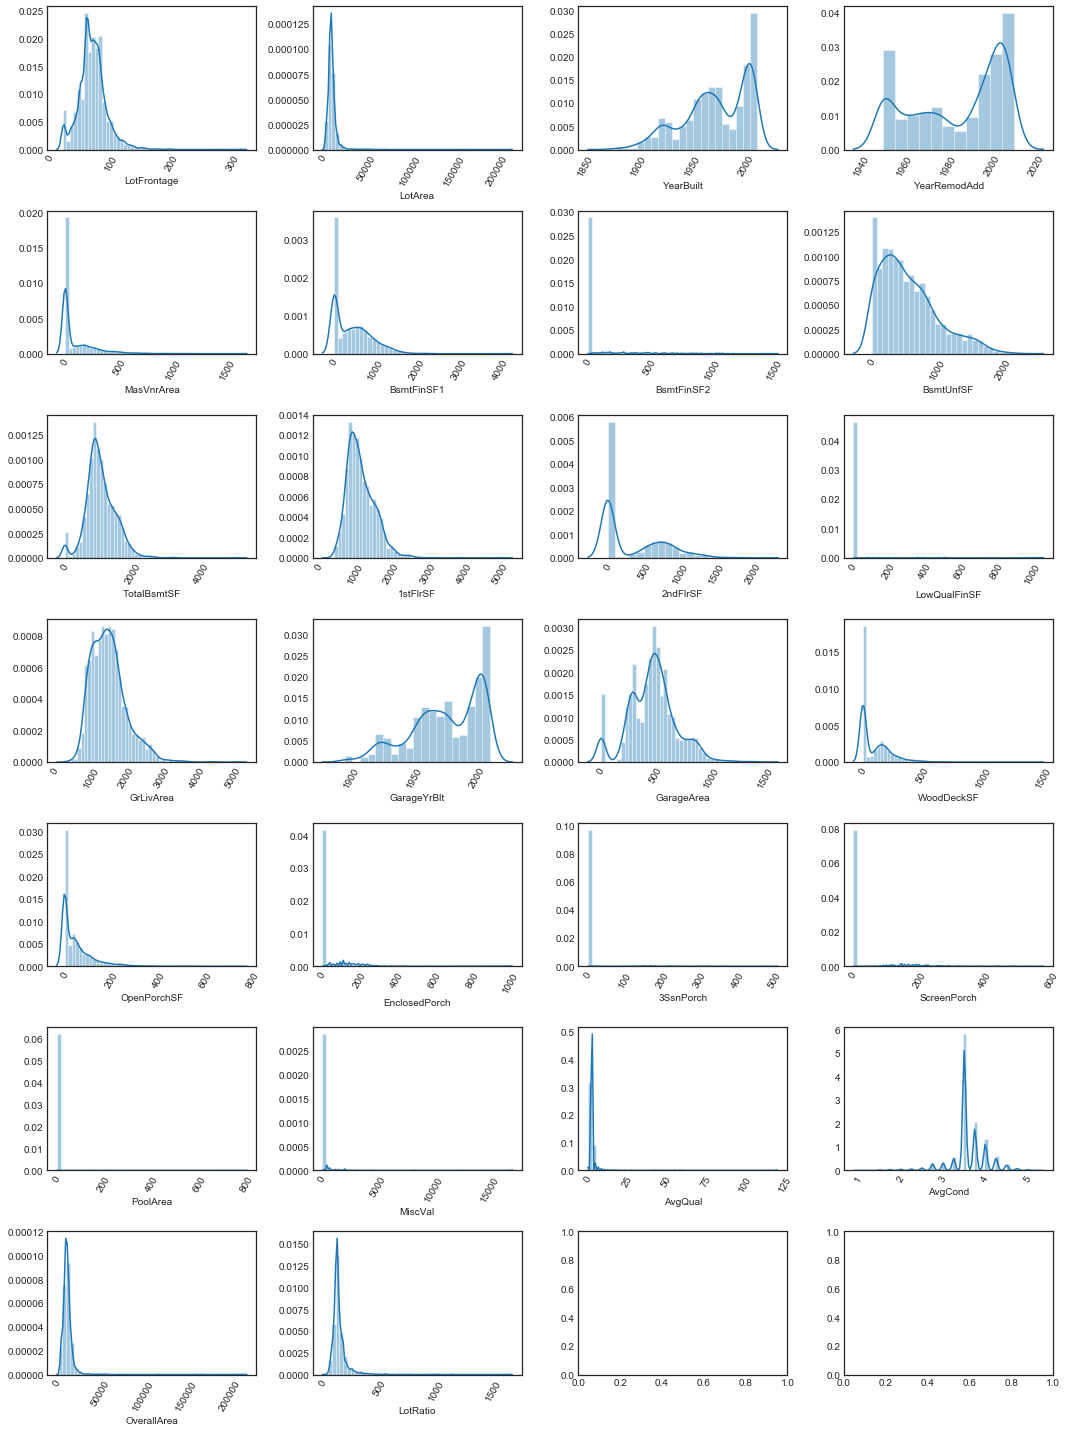

In [16]:
# inspect distributions of quantitatives including new ones
plot_cont_dists(nrows=7, ncols=4, data=quants_data.drop(columns=['SalePrice']), figsize=(15, 20))

In [17]:
# find minimum value over all quantitatives
quants_min_nonzero = quants_data[quants_data != 0].min().min()
print(f"Minimum quantitative value is {quants_data.min().min()}")
print(f"Minimum nonzero quantitative value is {quants_min_nonzero}")

Minimum quantitative value is 0.0
Minimum nonzero quantitative value is 0.4444444444444444


Since the minimum nonzero quantitative value is $< 1$, we must set $log(var) < log$ (`quants_min`) if $var = 0$ in order not to interfere with monotonicity

In [18]:
# Columns to log transform
log_cols = quants_data.columns.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'AvgCond'])
log_cols

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'AvgQual',
       'OverallArea', 'LotRatio'],
      dtype='object')

In [19]:
# log transform SalePrice
clean.data = log_transform(data=clean.data, log_cols=['SalePrice'])
drop.data = log_transform(data=drop.data, log_cols=['SalePrice'])

In [20]:
# log transform most quantitatives
clean_edit.data = log_transform(data=clean_edit.data, log_cols=log_cols)
drop_edit.data = log_transform(data=drop_edit.data, log_cols=log_cols)

## Model selection and tuning 

### Create modeling datasets

In [21]:
# set col kinds attribute of HPDataFramePlus attribute for model data method
do_col_kinds(drop)
do_col_kinds(drop_edit)
do_col_kinds(clean)
do_col_kinds(clean_edit)

In [22]:
# model data
mclean = HPDataFramePlus(data=clean.get_model_data(response='log_SalePrice'))
mclean_edit = HPDataFramePlus(data=clean_edit.get_model_data(response='log_SalePrice'))
mdrop = HPDataFramePlus(data=drop.get_model_data(response='log_SalePrice'))
mdrop_edit = HPDataFramePlus(data=drop_edit.get_model_data(response='log_SalePrice'))

In [23]:
mclean.data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2916 entries, (train, 1) to (test, 2919)
Columns: 230 entries, LotFrontage to log_SalePrice
dtypes: float64(230)
memory usage: 5.2+ MB


In [24]:
mclean_edit.data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2916 entries, (train, 1) to (test, 2919)
Columns: 222 entries, LotShape to log_SalePrice
dtypes: float64(222)
memory usage: 5.0+ MB


In [25]:
mdrop.data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2916 entries, (train, 1) to (test, 2919)
Columns: 173 entries, LotFrontage to log_SalePrice
dtypes: float64(173)
memory usage: 4.0+ MB


In [26]:
mdrop_edit.data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2916 entries, (train, 1) to (test, 2919)
Columns: 176 entries, LotShape to log_SalePrice
dtypes: float64(176)
memory usage: 4.0+ MB


### Compare default models for baseline

In [27]:
hpdfs = [mclean, mdrop, mclean_edit, mdrop_edit]
data_names = ['clean', 'drop', 'clean_edit', 'drop_edit']
response = 'log_SalePrice'
model_data = build_model_data(hpdfs, data_names, response)

First we'll look at a selection of untuned models with default parameters to get a rough idea of which ones might have better performance. 

We'll use root mean squared error (RMSE) for our loss function. Since we have a relatively small dataset, we'll use cross-validation to estimate rmse for test data.

In [28]:
# fit some default regressor models
def_models = {'lasso': Lasso(), 
              'ridge': Ridge(),
              'bridge': BayesianRidge(),
              'pls': PLSRegression(), 
              'svr': SVR(),
              'knn': KNeighborsRegressor(),
              'mlp': MLPRegressor(),
              'dectree': DecisionTreeRegressor(random_state=27),
              'extratree': ExtraTreeRegressor(random_state=27),
              'xgb': XGBRegressor(objective='reg:squarederror', random_state=27, n_jobs=-1)}


fit_def_models = fit_default_models(model_data, def_models)

In [29]:
# compare default models 
def_comp_df = compare_performance(fit_def_models, model_data, random_state=27)
def_comp_df.sort_values(by=('clean', 'cv_rmse')).reset_index(drop=True)

data             model        clean                   drop            \
performance              train_rmse   cv_rmse   train_rmse   cv_rmse   
0               bridge    0.0950012  0.115226    0.0988284   0.11371   
1                ridge    0.0948572  0.116246     0.099311  0.114194   
2                  xgb    0.0853461  0.122093    0.0895599  0.123479   
3                  pls     0.122064  0.127405     0.127452  0.133998   
4                  svr     0.122741  0.134491     0.123251   0.13529   
5                  mlp     0.116434  0.172462     0.123199  0.182601   
6              dectree  2.93011e-05  0.200113  2.52372e-05  0.205864   
7                  knn     0.164677   0.20921     0.161079  0.201135   
8            extratree  2.26808e-05  0.211913  1.40429e-05  0.216413   
9                lasso     0.399557  0.399865     0.399557  0.399721   

data          clean_edit              drop_edit            
performance   train_rmse   cv_rmse   train_rmse   cv_rmse  
0               0.094478   0.11409    0.0996576  0.115962  
1               0.094225  0.113706    0.0998434  0.116375  
2              0.0876669  0.123595    0.0889219  0.126636  
3               0.130416   0.13708     0.133912  0.139404  
4               0.120197  0.131894     0.123082  0.134709  
5               0.113073  0.162779     0.122168  0.171919  
6            3.15449e-05  0.206949  2.48969e-05  0.200551  
7               0.153413  0.194985     0.153466   0.18835  
8            1.66016e-05  0.209181  1.87349e-05  0.213926  
9               0.399557  0.400058     0.399557  0.399743

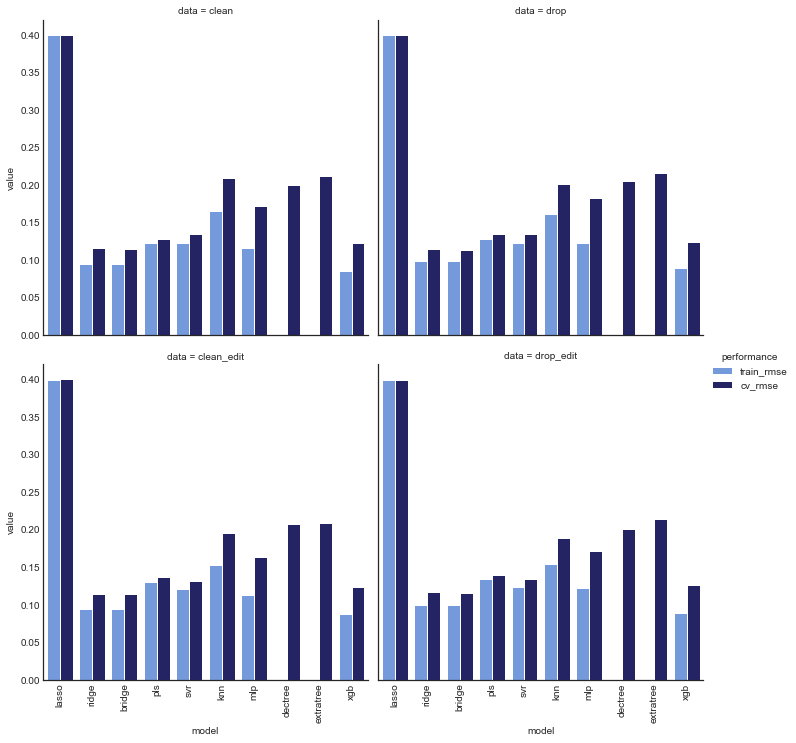

In [30]:
# compare train and cv performance for each dataset
data_palette = {'train_rmse': 'cornflowerblue', 'cv_rmse': 'midnightblue'}
plot_model_comp(def_comp_df, col='data', hue='performance', kind='bar',
                palette=data_palette, col_wrap=2)

Unsurprisingly, all models (with the exception of `lasso` regression) had worse CV error than train error. However, for some models the difference was much greater, and these are likely overfitting. In particular, `dectree`, `extratree` had cv error roughly 5 orders of magnitude greater than train error, and `mlp`, `knn`, and `xgb` also saw significant increases.

The other models (`ridge`, `bridge`, `pls` and `svr`) saw slighter differences in cv and train errors, and are thus less likely overfitting.

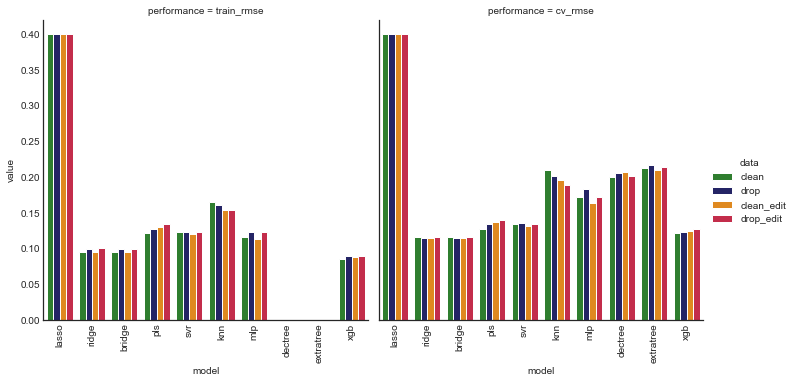

In [31]:
# compare train and cv error across datasets
perf_palette = {'drop': 'midnightblue', 'clean': 'forestgreen', 'drop_edit': 'crimson', 
           'clean_edit': 'darkorange'}
plot_model_comp(def_comp_df, col='performance', hue='data', kind='bar',
                palette=perf_palette)

Based on cv rmse, the most promising models appear to be `ridge`, `bridge`, `xgb`, `svr`, and `pls`, which are ridge, Bayesian ridge, gradient boosted decision tree, support vector and partial least squared regressors, respectively.

In [32]:
drop_cols = [(data_name, 'train_rmse') for data_name in data_names]
def_comp_cv = def_comp_df.drop(columns=drop_cols).sort_values(by=('clean', 'cv_rmse'))
def_comp_cv

data,model,clean,drop,clean_edit,drop_edit
performance,,cv_rmse,cv_rmse,cv_rmse,cv_rmse
2,bridge,0.115226,0.11371,0.11409,0.115962
1,ridge,0.116246,0.114194,0.113706,0.116375
9,xgb,0.122093,0.123479,0.123595,0.126636
3,pls,0.127405,0.133998,0.13708,0.139404
4,svr,0.134491,0.13529,0.131894,0.134709
6,mlp,0.172462,0.182601,0.162779,0.171919
7,dectree,0.200113,0.205864,0.206949,0.200551
5,knn,0.20921,0.201135,0.194985,0.18835
8,extratree,0.211913,0.216413,0.209181,0.213926


Almost all models had an improvement in cv rmse when features were added, so it appears the feature engineering was warranted.

In [33]:
# top models by cv performance for each data set
rank_models_on_data(def_comp_cv, model_data)

data,model,clean,drop,clean_edit,drop_edit
performance,,cv_rmse,cv_rmse,cv_rmse,cv_rmse
2,bridge,1,1,2,1
1,ridge,2,2,1,2
9,xgb,3,3,3,3
3,pls,4,4,5,5
4,svr,5,5,4,4
6,mlp,6,6,6,6
7,dectree,7,8,8,8
5,knn,8,7,7,7
8,extratree,9,9,9,9


The top five models were consistent across all four versions of the dataset, and were the promising models identified earlier. In order, they are `ridge`, `bridge`, `xgb`, with `svr` and `pls` tied for fourth.

In [34]:
# rank model performance across data sets
rank_models_across_data(def_comp_cv, model_data)

data,model,clean,drop,clean_edit,drop_edit
performance,,cv_rmse,cv_rmse,cv_rmse,cv_rmse
2,bridge,3,1,2,4
1,ridge,3,2,1,4
9,xgb,1,2,3,4
3,pls,1,2,3,4
4,svr,2,4,1,3
6,mlp,3,4,1,2
7,dectree,1,3,4,2
5,knn,4,3,2,1
8,extratree,2,4,1,3


The top model, `ridge` performed best on `clean_edit` and `drop_edit`. The next best model, `bridge` performed best on `clean` and `clean_edit`. Third and fourth `xgb` and `pls` performed best on `clean` and `drop`. Finally `svr` performed best on `clean_edit` and `drop_edit`.

### Tune best individual models

Here we'll focus on tuning the most promising models from the [last section](#Compare-models). We'll use both `clean_edit` and `drop_edit` since the top model performed best on these.

In [35]:
# retain top 5 models
drop_models = ['lasso', 'dectree', 'extratree', 'knn', 'mlp']
models = remove_models(fit_def_models, drop_models)

In [36]:
try:
    # drop models for clean and drop data
    models.pop('clean')
    models.pop('drop')
    # drop clean and drop data
    model_data.pop('clean')
    model_data.pop('drop')
except KeyError:
    pass

print(f'Promising models are {list(models["clean_edit"].keys())}')

Promising models are ['ridge', 'bridge', 'pls', 'svr', 'xgb']


In [38]:
# train test input output for clean_edit (y_test values are NaN)
X_ce_train = model_data['clean_edit']['X_clean_edit_train']
X_ce_test = model_data['clean_edit']['X_clean_edit_test']
y_ce_train = model_data['clean_edit']['y_clean_edit_train']

# train test input output for clean_edit (y_test values are NaN)
X_de_train = model_data['drop_edit']['X_drop_edit_train']
X_de_test = model_data['drop_edit']['X_drop_edit_test']
y_de_train = model_data['drop_edit']['y_drop_edit_train']

#### Ridge regression

[Ridge regression](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) is linear least squares with an $\ell_2$ regularization term. We'll fit default ridge regression models and then tune for comparison.

In [39]:
# Default ridge regression models
ridge_models = defaultdict(dict)
ridge_models['clean_edit']['ridge_def'] = Ridge().fit(X_ce_train, y_ce_train)
ridge_models['drop_edit']['ridge_def'] = Ridge().fit(X_de_train, y_de_train)

Bayesian hyperparameter optimization is an efficient tuning method. We'll optimize with respect to cv rmse

In [40]:
# ridge regression hyperparameters search space
ridge_space = {'alpha': hp.loguniform('alpha', low=-3*np.log(10), high=2*np.log(10))}

# container for hyperparameter search trials and results
model_ho_results = defaultdict(dict)

# store trial objects for restarting training
model_ho_results['clean_edit']['ridge_tuned'] = {'trials': Trials(), 'params': None}
model_ho_results['drop_edit']['ridge_tuned'] = {'trials': Trials(), 'params': None}

In [41]:
# optimize hyperparameters
model_ho_results['clean_edit']['ridge_tuned'] = \
                ho_results(obj=ho_cv_rmse, space=ridge_space, 
                           est_name='ridge', X_train=X_ce_train, 
                           y_train=y_ce_train, 
                           max_evals=100, random_state=27,
                           trials=model_ho_results['clean_edit']['ridge_tuned']['trials'])
model_ho_results['drop_edit']['ridge_tuned'] = \
                ho_results(obj=ho_cv_rmse, space=ridge_space, 
                           est_name='ridge', X_train=X_de_train, 
                           y_train=y_de_train, 
                           max_evals=100, random_state=27,
                           trials=model_ho_results['drop_edit']['ridge_tuned']['trials'])

100%|██████████| 100/100 [00:07<00:00, 13.32it/s, best loss: 0.11564439386901282]


In [42]:
%%capture
# create and fit models with optimal hyperparameters
ridge_models['clean_edit']['ridge_tuned'] = \
                    Ridge(**model_ho_results['clean_edit']['ridge_tuned']['params'])
ridge_models['drop_edit']['ridge_tuned'] = \
                    Ridge(**model_ho_results['drop_edit']['ridge_tuned']['params'])
ridge_models['clean_edit']['ridge_tuned'].fit(X_ce_train, y_ce_train)
ridge_models['drop_edit']['ridge_tuned'].fit(X_de_train, y_de_train)

In [43]:
# compare Ridge regression models
compare_performance(ridge_models, model_data, random_state=27)

data               model clean_edit           drop_edit          
performance              train_rmse  cv_rmse train_rmse   cv_rmse
0              ridge_def   0.094225  0.11256  0.0998434  0.115635
1            ridge_tuned  0.0950445  0.11315  0.0996629  0.114869

The ridge regression model trained on the `clean_edit` dataset and tuned with Bayesian search had the best cv rmse. We note however that the model trained on `drop_edit` had a , which is promising (a lower train rmse might indicate overfitting).

Since ridge regression is just linear regression with a regularization term, it's relatively straightfoward to interpret. We'll rank the features of the best model their coefficient weights.

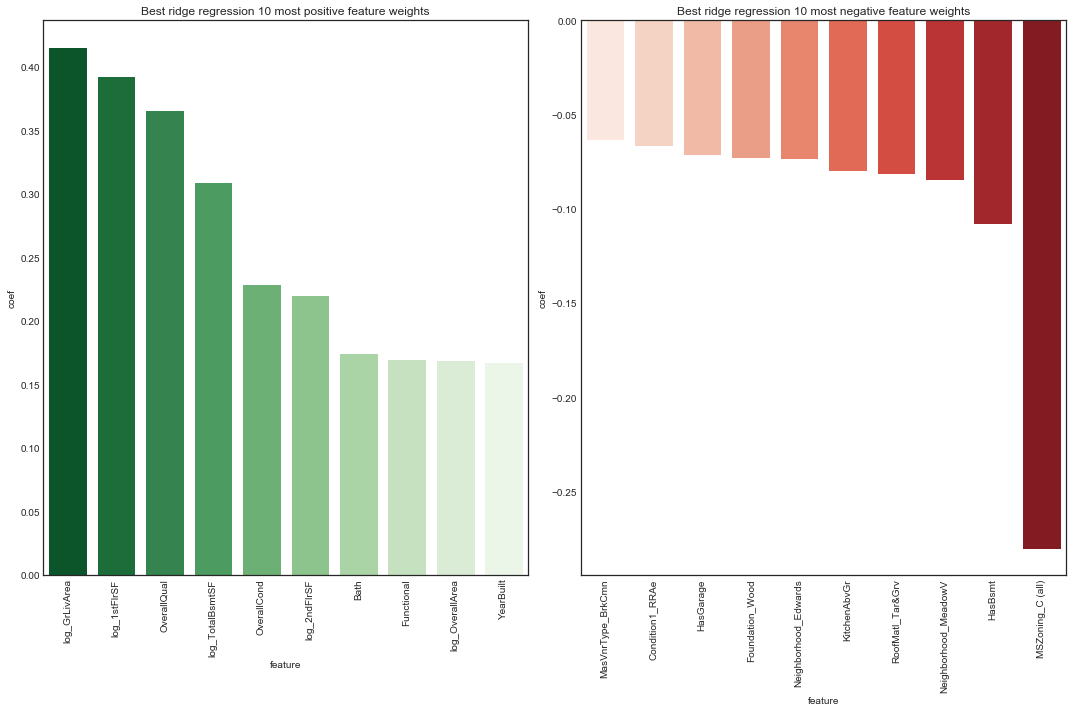

In [44]:
# Top and bottom 10 features in best ridge model
plot_features(ridge_models['clean_edit']['ridge_tuned'], 'ridge regression', X_ce_train, 10,
             figsize=(15, 10), rotation=90)

The rankings of most positive feature weights are not too suprising. The most postively weighted feature was overall quality. We note condition variables and size variables are prominent. 

The rankings of most negative feature weights are perhaps more surprising, in particular the presence of a basement and number of kitchens. Interestingly, several neighborhoods stand out as having a negative association with sale price. The most negatively weighted feature was the property being zoned commercial. 

In [45]:
# add tuned ridge models
models['clean_edit']['ridge_tuned'] = ridge_models['clean_edit']['ridge_tuned']
models['drop_edit']['ridge_tuned'] = ridge_models['drop_edit']['ridge_tuned']

#### Bayesian Ridge regression

[Bayesian ridge regression](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression)
is similar to ridge regression except it uses Bayesian methods to estimate the regularization parameter $\lambda$ from the data.

In [46]:
# Default Bayesian Ridge models
bridge_models = defaultdict(dict)
bridge_models['clean_edit']['bridge_def'] = BayesianRidge().fit(X_ce_train, y_ce_train)
bridge_models['drop_edit']['bridge_def'] = BayesianRidge().fit(X_de_train, y_de_train)

In [47]:
# bayesian ridge regression hyperparameter space
bridge_space = {'alpha_1': hp.loguniform('alpha_1', low=-9*np.log(10), high=3*np.log(10)),
                'alpha_2': hp.loguniform('alpha_2', low=-9*np.log(10), high=3*np.log(10)),
                'lambda_1': hp.loguniform('lambda_1', low=-9*np.log(10), high=3*np.log(10)),
                'lambda_2': hp.loguniform('lambda_2', low=-9*np.log(10), high=3*np.log(10))}

# store trial objects for restarting training
model_ho_results['clean_edit']['bridge_tuned'] = {'trials': Trials(), 'params': None}
model_ho_results['drop_edit']['bridge_tuned'] = {'trials': Trials(), 'params': None}

In [48]:
# optimize hyperparameters
model_ho_results['clean_edit']['bridge_tuned'] = \
                ho_results(obj=ho_cv_rmse, space=bridge_space, 
                           est_name='bridge', X_train=X_ce_train, 
                           y_train=y_ce_train, 
                           max_evals=100, random_state=27,
                           trials=model_ho_results['clean_edit']['bridge_tuned']['trials'])
model_ho_results['drop_edit']['bridge_tuned'] = \
                ho_results(obj=ho_cv_rmse, space=bridge_space, 
                           est_name='bridge', X_train=X_de_train, 
                           y_train=y_de_train, 
                           max_evals=100, random_state=27,
                           trials=model_ho_results['drop_edit']['bridge_tuned']['trials'])

100%|██████████| 100/100 [00:27<00:00,  3.66it/s, best loss: 0.11576647439940951]


In [49]:
%%capture
# add and fit models with optimal hyperparameters
bridge_models['clean_edit']['bridge_tuned'] = \
            BayesianRidge(**model_ho_results['clean_edit']['bridge_tuned']['params'])
bridge_models['drop_edit']['bridge_tuned'] = \
            BayesianRidge(**model_ho_results['drop_edit']['bridge_tuned']['params'])
bridge_models['clean_edit']['bridge_tuned'].fit(X_ce_train, y_ce_train)
bridge_models['drop_edit']['bridge_tuned'].fit(X_de_train, y_de_train)

In [50]:
# compare Ridge regression models
compare_performance(bridge_models, model_data, random_state=27)

data                model clean_edit            drop_edit          
performance               train_rmse   cv_rmse train_rmse   cv_rmse
0              bridge_def   0.094478  0.113612  0.0996576  0.114887
1            bridge_tuned    0.09467  0.114397  0.0996135  0.115072

As with ordinary ridge regression, the Bayesian ridge model trained on the `clean_edit` data and tuned with Bayesian search had the best cv rmse.

As with ridge regression, the model is straightforward to interpret.

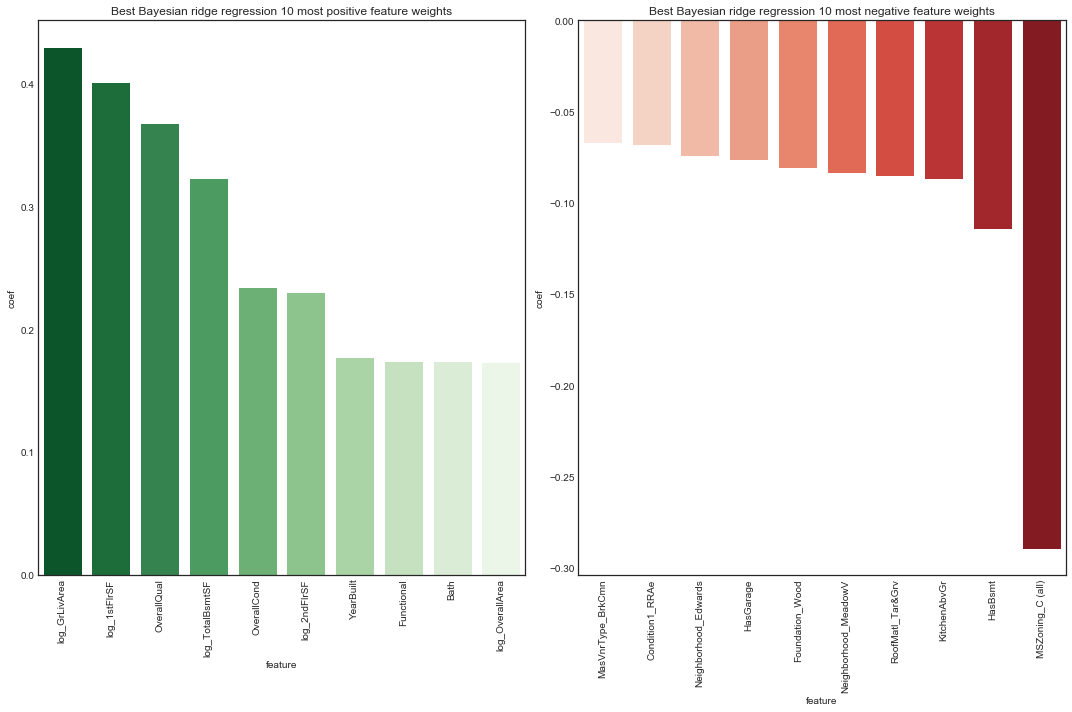

In [51]:
# Top and bottom 10 features in best Bayesian ridge model
plot_features(bridge_models['clean_edit']['bridge_tuned'], 'Bayesian ridge regression', X_ce_train, 10,
             figsize=(15, 10), rotation=90)

Feature weight rankings are nearly identical to the ridge model.

In [52]:
# add tuned bridge models
models['clean_edit']['bridge_tuned'] = bridge_models['clean_edit']['bridge_tuned']
models['drop_edit']['bridge_tuned'] = bridge_models['drop_edit']['bridge_tuned']

#### Partial Least Squares

[Partial least squares regression](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html) stands out among the other models we're tuning here as the only dimensional reduction method. It is [well-suited to multicollinearity in the input data](https://scikit-learn.org/stable/modules/cross_decomposition.html#cross-decomposition).

In [53]:
# Default partial least squares models
pls_models = defaultdict(dict)
pls_models['clean_edit']['pls_def'] = PLSRegression().fit(X_ce_train, y_ce_train)
pls_models['drop_edit']['pls_def'] = PLSRegression().fit(X_de_train, y_de_train)

The main hyperparameter of interest in partial least squared is the number of components (analogous to the number of components in principal component analysis) which is essentially the number of dimensions of the reduced dataset.

In [54]:
# partial least squares hyperparameter spaces
pls_ce_space = {'max_iter': ho_scope.int(hp.quniform('max_iter', low=200, 
                                                     high=10000, q=10)),
               'n_components': ho_scope.int(hp.quniform('n_components', low=2, 
                                                        high=X_ce_train.shape[1] - 2, q=1))
                }
pls_de_space = {'max_iter': ho_scope.int(hp.quniform('max_iter', low=200, 
                                                     high=10000, q=10)),
               'n_components': ho_scope.int(hp.quniform('n_components', low=2, 
                                                        high=X_de_train.shape[1] - 2, q=1))}

# store trial objects for restarting training
model_ho_results['clean_edit']['pls_tuned'] = {'trials': Trials(), 'params': None}
model_ho_results['drop_edit']['pls_tuned'] = {'trials': Trials(), 'params': None}

In [55]:
# optimize hyperparameters
model_ho_results['clean_edit']['pls_tuned'] = \
                ho_results(obj=ho_cv_rmse, space=pls_ce_space, est_name='pls', 
                           X_train=X_ce_train, y_train=y_ce_train, max_evals=100, 
                           random_state=27,
                           trials=model_ho_results['clean_edit']['pls_tuned']['trials'])
model_ho_results['drop_edit']['pls_tuned'] = \
                ho_results(obj=ho_cv_rmse, space=pls_de_space, est_name='pls',
                           X_train=X_de_train, y_train=y_de_train, max_evals=100,
                           random_state=27,
                           trials=model_ho_results['drop_edit']['pls_tuned']['trials'])

100%|██████████| 100/100 [01:02<00:00,  1.60it/s, best loss: 0.11672287624670073]


In [56]:
%%capture
# workaround to cast results of hyperopt param search to correct type
conv_params = ['max_iter', 'n_components']
model_ho_results['clean_edit']['pls_tuned']['params'] = \
            convert_to_int(model_ho_results['clean_edit']['pls_tuned']['params'], 
                           conv_params)
model_ho_results['drop_edit']['pls_tuned']['params'] = \
            convert_to_int(model_ho_results['drop_edit']['pls_tuned']['params'], 
                           conv_params)

# add and fit models with optimal hyperparameters
pls_models['clean_edit']['pls_tuned'] = \
            PLSRegression(**model_ho_results['clean_edit']['pls_tuned']['params'])
pls_models['drop_edit']['pls_tuned'] = \
            PLSRegression(**model_ho_results['drop_edit']['pls_tuned']['params'])
pls_models['clean_edit']['pls_tuned'].fit(X_ce_train, y_ce_train)
pls_models['drop_edit']['pls_tuned'].fit(X_de_train, y_de_train)

In [57]:
# inspect pls optimal parameters
print(f"On the clean_edit data, optimal PLS parameters are: \n\t {model_ho_results['clean_edit']['pls_tuned']['params']}")
print(f"On the drop_edit data, optimal PLS parameters are: \n\t {model_ho_results['drop_edit']['pls_tuned']['params']}")

On the clean_edit data, optimal PLS parameters are: 
	 {'max_iter': 5690, 'n_components': 12}
On the drop_edit data, optimal PLS parameters are: 
	 {'max_iter': 2640, 'n_components': 16}


Interestingly, only a small number of components were deemed optimal! It's worth recalling that this likely reflects a local minimum in the loss function, so the result should be taken with a grain of salt. However, it is interesting to note that such a low number of components are sufficient to get a competitive model.

In [58]:
# compare Bayesian Ridge models on clean and edit datasets
compare_performance(pls_models, model_data)

data             model clean_edit            drop_edit          
performance            train_rmse   cv_rmse train_rmse   cv_rmse
0              pls_def   0.130416  0.136774   0.133912  0.139224
1            pls_tuned  0.0948243  0.115228  0.0989862  0.116016

In contrast to ridge and Bayesian ridge regression, the tuned partial least squares had slightly lower cv rmse on the `drop_edit` dataset. This cv rmse is very close to that of tuned ridge and Bayesian ridge  models -- it's remarkable that only 16 components are required!

In [59]:
# add tuned pls models
models['clean_edit']['pls_tuned'] = pls_models['clean_edit']['pls_tuned']
models['drop_edit']['pls_tuned'] = pls_models['drop_edit']['pls_tuned']

#### Support Vector Machine

In [60]:
# Default support vector models
svr_models = defaultdict(dict)
svr_models['clean_edit']['svr_def'] = SVR().fit(X_ce_train, y_ce_train)
svr_models['drop_edit']['svr_def'] = SVR().fit(X_de_train, y_de_train)

In [61]:
# hyperparameter space for SVR with rbf kernel
svr_space = {'gamma': hp.loguniform('gamma', low=-3*np.log(10), high=2*np.log(10)),
             'C': hp.loguniform('C', low=-3*np.log(10), high=2*np.log(10)),
             'epsilon': hp.loguniform('epsilon', low=-3*np.log(10), high=2*np.log(10))
            }

# store trial objects for restarting training
model_ho_results['clean_edit']['svr_tuned'] = {'trials': Trials(), 'params': None}
model_ho_results['drop_edit']['svr_tuned'] = {'trials': Trials(), 'params': None}

In [62]:
# optimize hyperparameters
model_ho_results['clean_edit']['svr_tuned'] = \
            ho_results(obj=ho_cv_rmse, space=svr_space, est_name='svr', 
                       X_train=X_ce_train, y_train=y_ce_train, max_evals=50,
                       random_state=27,
                       trials=model_ho_results['clean_edit']['svr_tuned']['trials'])
model_ho_results['drop_edit']['svr_tuned'] = \
            ho_results(obj=ho_cv_rmse, space=svr_space, est_name='svr', 
                       X_train=X_de_train, y_train=y_de_train, max_evals=50,
                       random_state=27,
                       trials=model_ho_results['drop_edit']['svr_tuned']['trials'])

100%|██████████| 50/50 [01:32<00:00,  1.84s/it, best loss: 0.11424890264814005]


In [63]:
%%capture
# fit models with optimal hyperparameters
svr_models['clean_edit']['svr_tuned'] = \
                        SVR(**model_ho_results['clean_edit']['svr_tuned']['params'])
svr_models['drop_edit']['svr_tuned'] = \
                        SVR(**model_ho_results['drop_edit']['svr_tuned']['params'])
svr_models['clean_edit']['svr_tuned'].fit(X_ce_train, y_ce_train)
svr_models['drop_edit']['svr_tuned'].fit(X_de_train, y_de_train)

In [64]:
# compare SVR model performance on clean and edit datasets
svr_comp_df = compare_performance(svr_models, model_data)

In [ ]:
svr_comp_df

As with all previous models, we're seeing better performance on `drop_edit`. Again, a higher train rmse on `drop_edit` but a lower cv rmse is a positive sign.

In [65]:
# add tuned svr models
models['clean_edit']['svr_tuned'] = svr_models['clean_edit']['svr_tuned']
models['drop_edit']['svr_tuned'] = svr_models['drop_edit']['svr_tuned']

####  Gradient boosted trees

In [66]:
# Default gradient boost tree models
xgb_models = defaultdict(dict)
xgb_models['clean_edit']['xgb_def'] = XGBRegressor(objective='reg:squarederror', random_state=27, n_jobs=-1)
xgb_models['drop_edit']['xgb_def'] = XGBRegressor(objective='reg:squarederror', random_state=27, n_jobs=-1)
xgb_models['clean_edit']['xgb_def'].fit(X_ce_train.values, y_ce_train.values)
xgb_models['drop_edit']['xgb_def'].fit(X_de_train.values, y_de_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [67]:
# hyperparameter spaces
xgb_space = {'max_depth': ho_scope.int(hp.quniform('max_depth', low=1, high=3, q=1)),
             'n_estimators': ho_scope.int(hp.quniform('n_estimators', low=100, high=500, q=50)),
             'learning_rate': hp.loguniform('learning_rate', low=-4*np.log(10), high=0),
             'gamma': hp.loguniform('gamma', low=-3*np.log(10), high=2*np.log(10)),
             'min_child_weight': ho_scope.int(hp.quniform('min_child_weight', low=1, high=7, q=1)),
             'subsample': hp.uniform('subsample', low=0.25, high=1),
             'colsample_bytree': hp.uniform('colsample_bytree', low=0.25, high=1),
             'colsample_bylevel': hp.uniform('colsample_bylevel', low=0.25, high=1),
             'colsample_bynode': hp.uniform('colsample_bynode', low=0.25, high=1),
             'reg_lambda': hp.loguniform('reg_lambda', low=-2*np.log(10), high=2*np.log(10)),
             'reg_alpha': hp.loguniform('reg_alpha', low=-1*np.log(10), high=1*np.log(10)),
            }

# store trial objects for restarting training
model_ho_results['clean_edit']['xgb_tuned'] = {'trials': Trials(), 'params': None}
model_ho_results['drop_edit']['xgb_tuned'] = {'trials': Trials(), 'params': None}

In [68]:
# optimize hyperparameters
model_ho_results['clean_edit']['xgb_tuned'] = \
            ho_results(obj=ho_cv_rmse, space=xgb_space, est_name='xgb',
                       X_train=X_ce_train, y_train=y_ce_train, max_evals=50,
                       random_state=27,
                       trials=model_ho_results['clean_edit']['xgb_tuned']['trials'])
model_ho_results['drop_edit']['xgb_tuned'] = \
            ho_results(obj=ho_cv_rmse, space=xgb_space, est_name='xgb',
                       X_train=X_de_train, y_train=y_de_train, max_evals=50, 
                       random_state=27,
                       trials=model_ho_results['drop_edit']['xgb_tuned']['trials'])

100%|██████████| 50/50 [08:56<00:00, 10.74s/it, best loss: 0.12018590987034897]


In [69]:
%%capture
# convert params to int
conv_params = ['max_depth', 'min_child_weight', 'n_estimators']
model_ho_results['clean_edit']['xgb_tuned']['params'] = \
        convert_to_int(model_ho_results['clean_edit']['xgb_tuned']['params'], conv_params)
model_ho_results['clean_edit']['xgb_tuned']['params'] = \
        convert_to_int(model_ho_results['clean_edit']['xgb_tuned']['params'], conv_params)

# add and fit models with optimal hyperparameters
fixed_params = {'objective': 'reg:squarederror', 'n_jobs': -1, 'random_state': 27}
xgb_models['clean_edit']['xgb_tuned'] = \
        XGBRegressor(**{**model_ho_results['clean_edit']['xgb_tuned']['params'], 
                        **fixed_params})
xgb_models['drop_edit']['xgb_tuned'] = \
        XGBRegressor(**{**model_ho_results['clean_edit']['xgb_tuned']['params'], 
                        **fixed_params})
xgb_models['clean_edit']['xgb_tuned'].fit(X_ce_train.values, y_ce_train.values)
xgb_models['drop_edit']['xgb_tuned'].fit(X_de_train.values, y_de_train.values)

In [71]:
# compare XGBoost models on clean_edit and drop_edit datasets
xgb_comp_df = compare_performance(xgb_models, model_data)
xgb_comp_df

data             model clean_edit            drop_edit          
performance            train_rmse   cv_rmse train_rmse   cv_rmse
0              xgb_def  0.0876669  0.125045  0.0889219  0.125903
1            xgb_tuned  0.0772716  0.113871  0.0795258  0.117488

In contrast to all previous models, the gradient boosted tree regressor had a lower cv rmse on `clean_edit`, but similarly to previous models train rmse was higher.

We can rank the features by importance (in this case, the number of times the feature was used to split a tree across all trees in the forest).

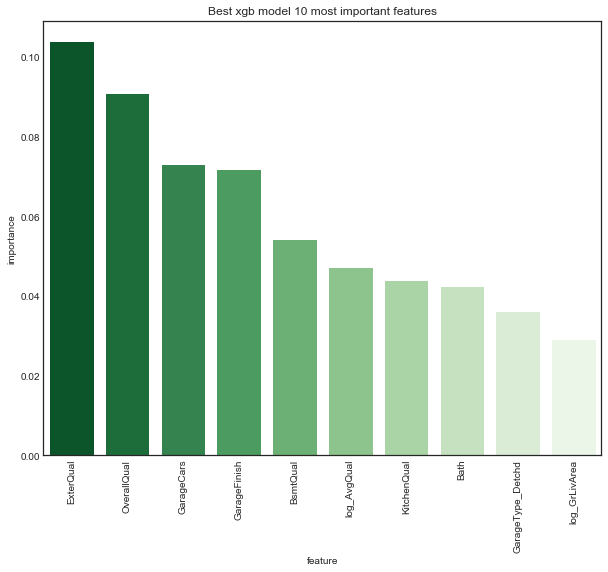

In [72]:
# top 20 feature importances of xgb model on drop_edit data
plot_xgb_features(xgb_models['drop_edit']['xgb_tuned'], X_de_train, 10, figsize=(10, 8),
                  rotation=90)

On the `drop_edit` data, the top ten features for the gradient boosted trees regression model seem quite different from the top ten features of [ridge regression](#Ridge-regressor). Only `OverallQual` and `log_GrLivArea` appear in both, and whereas both rank `OverallQual` third, `ridge` ranks `log_GrLivArea` first while `xgb` ranks it tenth. While the top `ridge` features seemed plausible and natural, some of the top `xgb` features seem more surpising, especially the highest ranked feature `GarageType_Detached`.

In [73]:
# replace default models with tuned models
models['clean_edit']['xgb_tuned'] = xgb_models['clean_edit']['xgb_tuned']
models['drop_edit']['xgb_tuned'] = xgb_models['drop_edit']['xgb_tuned']

#### Compare tuned models and save parameters

In [74]:
# compare results of tuned models
tuned_comp_df = compare_performance(models, model_data, random_state=27)
tuned_comp_df.sort_values(by=('clean_edit', 'cv_rmse')).reset_index(drop=True)

data                model clean_edit            drop_edit          
performance               train_rmse   cv_rmse train_rmse   cv_rmse
0               svr_tuned    0.06929  0.112236  0.0911838  0.112445
1             ridge_tuned  0.0950445  0.113011  0.0996629  0.116393
2            bridge_tuned    0.09467  0.113658  0.0996135  0.114628
3                  bridge   0.094478  0.113733  0.0996576  0.115385
4                   ridge   0.094225  0.114597  0.0998434   0.11497
5               xgb_tuned  0.0772716  0.114933  0.0795258   0.11772
6               pls_tuned  0.0948243  0.115411  0.0989862  0.115752
7                     xgb  0.0876669  0.123048  0.0889219  0.126444
8                     svr   0.120197  0.131465   0.123082  0.134494
9                     pls   0.130416  0.136702   0.133912  0.140016

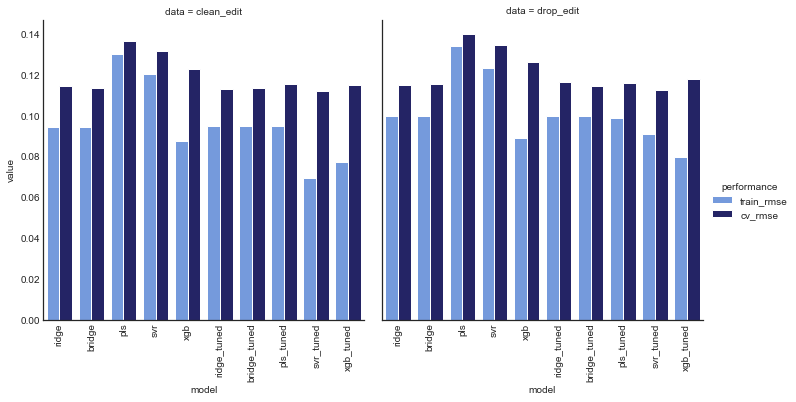

In [75]:
# compare tuned model train and cv performance on clean and edit datasets
plot_model_comp(tuned_comp_df, col='data', hue='performance', kind='bar', palette=data_palette)

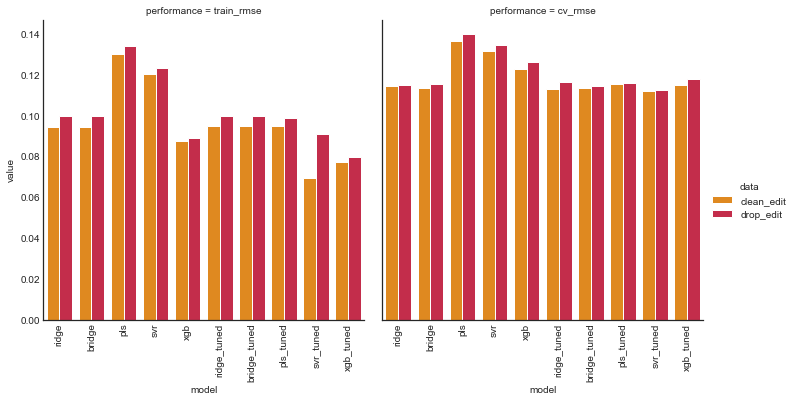

In [76]:
# compare clean and edit performance for train and cv error
plot_model_comp(tuned_comp_df, col='performance', hue='data', kind='bar', palette=perf_palette)

In [78]:
# pickle hyperopt trials and results
pickle_to_file(model_ho_results, '../training/model_tuning_results.pkl')

# pickle tuned models
pickle_to_file(models, '../training/tuned_models.pkl')

### Ensembles

In [82]:
# unpickle tuned models from last section
tuned_models = pickle_from_file('../training/tuned_models.pkl')

#### Voting

Voting ensembles predict a weighted average of base models. 

We'll use the implementation [`sklearn.ensemble.VotingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html). Unfortunately `sklearn.PLSRegressor`'s `predict` method returns arrays of size `(n_samples, 1)` rather than `(n_samples,)` like all all other models. This throws an error when passed in as an estimator to `cross_val_score` so we won't use it as a base model. We also won't use `bridge` since its feature weights were nearly identical to `ridge`, so in the end our voting regressor will consist of three base models: ridge, support vector and gradient boosted tree regression.

In [83]:
tuned_models['clean_edit'].keys()

dict_keys(['ridge', 'bridge', 'pls', 'svr', 'xgb', 'ridge_tuned', 'bridge_tuned', 'pls_tuned', 'svr_tuned', 'xgb_tuned'])

In [84]:
drop_models = ['ridge', 'bridge', 'pls', 'svr', 'xgb', 'bridge_tuned', 
               'pls_tuned']
base_pretuned = remove_models(tuned_models, drop_models)

##### Default base and uniform weights

For a baseline, we'll look at a voting ensemble of default base models with uniform weights

In [85]:
%%capture
# Default models for Voting Regressor
base_def = [('ridge', Ridge()), 
            ('svr', SVR()), 
            ('xgb', XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=27))]

# Voting ensembles with uniform weights and untuned base models
ensembles = defaultdict(dict)
ensembles['clean_edit']['voter_def'] = VotingRegressor(base_def, n_jobs=-1)
ensembles['drop_edit']['voter_def'] = VotingRegressor(base_def, n_jobs=-1)
ensembles['clean_edit']['voter_def'].fit(X_ce_train.values, y_ce_train.values)
ensembles['drop_edit']['voter_def'].fit(X_de_train.values, y_de_train.values)

##### Pretuned base and uniform weights

We also consider a voting ensemble with pretuned base models and uniform weights.

In [86]:
%%capture
# Voting ensmebles with uniform weights for pretuned base models
ensembles['clean_edit']['voter_uniform_pretuned'] = \
         VotingRegressor(list(base_pretuned['clean_edit'].items()), n_jobs=-1)
ensembles['drop_edit']['voter_uniform_pretuned'] = \
         VotingRegressor(list(base_pretuned['drop_edit'].items()), n_jobs=-1)
ensembles['clean_edit']['voter_uniform_pretuned'].fit(X_ce_train.values, y_ce_train.values)
ensembles['drop_edit']['voter_uniform_pretuned'].fit(X_de_train.values, y_de_train.values)

In [87]:
# voting ensemble hyperparameters for pretuned base
weight_space = {'voter1': hp.uniform('voter1', low=0, high=1),
               'voter2': hp.uniform('voter2', low=0, high=1),
               'voter3': hp.uniform('voter3', low=0, high=1)
              }

voter_fixed_params = {'n_jobs': -1}


# container for hyperparameter search trials and results
ens_ho_results = defaultdict(dict)

# store trial objects for restarting training
ens_ho_results['clean_edit']['voter_pretuned'] = {'trials': Trials(), 'params': None}
ens_ho_results['drop_edit']['voter_pretuned'] = {'trials': Trials(), 'params': None}

In [88]:
# optimize weights for voting ensemble with pretuned base
ens_ho_results['clean_edit']['voter_pretuned'] = \
        ho_ens_results(obj=ho_ens_cv_rmse, space=weight_space, ens_name='voter', 
                       base_ests=base_pretuned['clean_edit'],
                       X_train=X_ce_train, y_train=y_ce_train,
                       fixed_params=voter_fixed_params,
                       pretuned=True, random_state=27, max_evals=50,
                       trials=ens_ho_results['clean_edit']['voter_pretuned']['trials'])
ens_ho_results['drop_edit']['voter_pretuned'] = \
        ho_ens_results(obj=ho_ens_cv_rmse, space=weight_space, ens_name='voter', 
                       base_ests=base_pretuned['drop_edit'],
                       X_train=X_de_train, y_train=y_de_train,
                       fixed_params=voter_fixed_params,
                       pretuned=True, random_state=27, max_evals=50,
                       trials=ens_ho_results['drop_edit']['voter_pretuned']['trials'])

100%|██████████| 50/50 [12:22<00:00, 14.85s/it, best loss: 0.11169063598085288]


In [89]:
%%capture
# store and normalize weights
ce_pretuned_weights = list(ens_ho_results['clean_edit']['voter_pretuned']['params'].values())
de_pretuned_weights = list(ens_ho_results['drop_edit']['voter_pretuned']['params'].values())
ce_pretuned_weights = convert_and_normalize_weights(ce_pretuned_weights)
de_pretuned_weights = convert_and_normalize_weights(de_pretuned_weights)

# add and fit voting ensembles of pretuned base estimators with tuned weights
ensembles['clean_edit']['voter_pretuned'] = \
                    VotingRegressor(list(base_pretuned['clean_edit'].items()), 
                                    weights=ce_pretuned_weights)
ensembles['drop_edit']['voter_pretuned'] = \
                    VotingRegressor(list(base_pretuned['drop_edit'].items()), 
                                    weights=de_pretuned_weights)
ensembles['clean_edit']['voter_pretuned'].fit(X_ce_train.values, y_ce_train.values)
ensembles['drop_edit']['voter_pretuned'].fit(X_de_train.values, y_de_train.values)

##### Fully tuned voter

Finally, we'll tune a voting regressors base model hyperparameters and voting weights simultaneously with Bayesian search.

In [90]:
# base hyperparameter spaces
ridge_base_space = {'alpha_ridge': hp.loguniform('alpha_ridge', low=-3*np.log(10), high=2*np.log(10))}
svr_base_space = {'gamma_svr': hp.loguniform('gamma_svr', low=-3*np.log(10), high=2*np.log(10)),
                  'C_svr': hp.loguniform('C_svr', low=-3*np.log(10), high=2*np.log(10)),
                  'epsilon_svr': hp.loguniform('epsilon_svr', low=-3*np.log(10), high=2*np.log(10))}
xgb_base_space = {'max_depth_xgb': ho_scope.int(hp.quniform('max_depth_xgb', low=1, high=3, q=1)),
                  'n_estimators_xgb': ho_scope.int(hp.quniform('n_estimators_xgb', low=100, high=500, q=50)),
                  'learning_rate_xgb': hp.loguniform('learning_rate_xgb', low=-4*np.log(10), high=0),
                  'gamma_xgb': hp.loguniform('gamma_xgb', low=-3*np.log(10), high=2*np.log(10)),
                  'min_child_weight_xgb': ho_scope.int(hp.quniform('min_child_weight_xgb', low=1, high=7, q=1)),
                  'subsample_xgb': hp.uniform('subsample_xgb', low=0.25, high=1),
                  'colsample_bytree_xgb': hp.uniform('colsample_bytree_xgb', low=0.25, high=1),
                  'colsample_bylevel_xgb': hp.uniform('colsample_bylevel_xgb', low=0.25, high=1),
                  'colsample_bynode_xgb': hp.uniform('colsample_bynode_xgb', low=0.25, high=1),
                  'reg_lambda_xgb': hp.loguniform('reg_lambda_xgb', low=-2*np.log(10), high=2*np.log(10)),
                  'reg_alpha_xgb': hp.loguniform('reg_alpha_xgb', low=-1*np.log(10), high=1*np.log(10)),
                 }

# voting ensemble hyperparameters for untuned base
base_space = {**ridge_base_space, **svr_base_space, **xgb_base_space}
voter_space = {**base_space, **weight_space}

# store trial objects for restarting training
ens_ho_results['clean_edit']['voter_tuned'] = {'trials': Trials(), 'params': None}
ens_ho_results['drop_edit']['voter_tuned'] = {'trials': Trials(), 'params': None}

In [91]:
# optimize all voting ensemble hyperparameters jointly
ens_ho_results['clean_edit']['voter_tuned'] = \
            ho_ens_results(obj=ho_ens_cv_rmse, space=voter_space, ens_name='voter', 
                           X_train=X_ce_train, y_train=y_ce_train, 
                           fixed_params=voter_fixed_params,
                           pretuned=False, random_state=27, max_evals=50,
                           trials=ens_ho_results['clean_edit']['voter_tuned']['trials'])
ens_ho_results['drop_edit']['voter_tuned'] = \
            ho_ens_results(obj=ho_ens_cv_rmse, space=voter_space, ens_name='voter', 
                           X_train=X_de_train, y_train=y_de_train, 
                           fixed_params=voter_fixed_params,
                           pretuned=False, random_state=27, max_evals=50,
                           trials=ens_ho_results['drop_edit']['voter_tuned']['trials'])

100%|██████████| 50/50 [07:55<00:00,  9.51s/it, best loss: 0.11927675656382479]


In [92]:
%%capture
# add and fit fully tuned voting ensembles 
ensembles['clean_edit']['voter_tuned'] = \
            voter_from_search_params(ens_ho_results['clean_edit']['voter_tuned']['params'],
                                     X_ce_train, y_ce_train, random_state=27)
ensembles['drop_edit']['voter_tuned'] = \
            voter_from_search_params(ens_ho_results['drop_edit']['voter_tuned']['params'],
                                     X_de_train, y_de_train, random_state=27)

#### Stacking

Stacking ensembles fit a meta models to the predictions of base models. To avoid overfitting, one can use folds to generate base models predictions.
We'll use the implementation [`mlxtend.StackingCVRegressor`](http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/). We'll also choose our meta models from the set of base models (ridge, support vector, and gradient boosted tree regression).

##### Default base and meta

For a baseline, we'll consider stack ensembles for which both base and meta models have default parameters. We'll use all three base models for each, and vary the meta model across the base models.

In [93]:
# add default base and meta without using features in secondary
ensembles = add_stacks(ensembles, model_data, suffix='def', 
                       use_features_in_secondary=False, random_state=27)

In [94]:
# add default base and meta using features in secondary
ensembles = add_stacks(ensembles, model_data, suffix='def', 
                       use_features_in_secondary=True, random_state=27)

##### Pretuned base and meta

Now we'll consider stack ensembles for which the base and meta models are already tuned. Again, we'll use all three base models and vary the meta model across the base models.

In [95]:
# add pretuned base and meta without using features in secondary
ensembles = add_stacks(ensembles, model_data, base_ests=base_pretuned, 
                       meta_ests=base_pretuned, suffix='pretuned', 
                       use_features_in_secondary=False, random_state=27)

In [96]:
# add pretuned base and meta using features in secondary
ensembles = add_stacks(ensembles, model_data, base_ests=base_pretuned, 
                       meta_ests=base_pretuned, suffix='pretuned', 
                       use_features_in_secondary=True, random_state=27)

##### Fully tuned stacks

Finally, we'll tune stack ensembles at once, that is we'll tune both base and meta models simultaneously. As before, we'll use all three base models and vary the meta model across the base models.

In [97]:
# meta hyperparameter spaces
ridge_meta_space = {'alpha_ridge_meta': hp.loguniform('alpha_ridge_meta', low=-3*np.log(10), high=2*np.log(10))}
svr_meta_space = {'gamma_svr_meta': hp.loguniform('gamma_svr_meta', low=-3*np.log(10), high=2*np.log(10)),
                  'C_svr_meta': hp.loguniform('C_svr_meta', low=-3*np.log(10), high=2*np.log(10)),
                  'epsilon_svr_meta': hp.loguniform('epsilon_svr_meta', low=-3*np.log(10), high=2*np.log(10))}
xgb_meta_space = {'max_depth_xgb_meta': ho_scope.int(hp.quniform('max_depth_xgb_meta', low=1, high=3, q=1)),
                  'n_estimators_xgb_meta': ho_scope.int(hp.quniform('n_estimators_xgb_meta', low=100, high=500, q=50)),
                  'learning_rate_xgb_meta': hp.loguniform('learning_rate_xgb_meta', low=-4*np.log(10), high=0),
                  'gamma_xgb_meta': hp.loguniform('gamma_xgb_meta', low=-3*np.log(10), high=2*np.log(10)),
                  'min_child_weight_xgb_meta': ho_scope.int(hp.quniform('min_child_weight_xgb_meta', low=1, high=7, q=1)),
                  'subsample_xgb_meta': hp.uniform('subsample_xgb_meta', low=0.25, high=1),
                  'colsample_bytree_xgb_meta': hp.uniform('colsample_bytree_xgb_meta', low=0.25, high=1),
                  'colsample_bylevel_xgb_meta': hp.uniform('colsample_bylevel_xgb_meta', low=0.25, high=1),
                  'colsample_bynode_xgb_meta': hp.uniform('colsample_bynode_xgb_meta', low=0.25, high=1),
                  'reg_lambda_xgb_meta': hp.loguniform('reg_lambda_xgb_meta', low=-2*np.log(10), high=2*np.log(10)),
                  'reg_alpha_xgb_meta': hp.loguniform('reg_alpha_xgb_meta', low=-1*np.log(10), high=1*np.log(10)),
                 }

###### `Ridge` meta

In [98]:
# ridge meta stack space
ridge_stack_space = {**ridge_meta_space, **base_space}

# store trial objects for restarting training
ens_ho_results['clean_edit']['stack_ridge_tuned'] = {'trials': Trials(), 'params': None}
ens_ho_results['drop_edit']['stack_ridge_tuned'] = {'trials': Trials(), 'params': None}

In [ ]:
# tune ridge stack without features in secondary
stack_fixed_params = {'n_jobs': -1, 'use_features_in_secondary': False}

ens_ho_results['clean_edit']['stack_ridge_tuned'] = \
        ho_ens_results(obj=ho_ens_cv_rmse, space=ridge_stack_space, ens_name='stack', 
                       X_train=X_ce_train,  y_train=y_ce_train, meta_name='ridge', 
                       fixed_params=stack_fixed_params, pretuned=False, 
                       random_state=27, max_evals=50,
                       trials=ens_ho_results['clean_edit']['stack_ridge_tuned']['trials'])
ens_ho_results['drop_edit']['stack_ridge_tuned'] = \
        ho_ens_results(obj=ho_ens_cv_rmse, space=ridge_stack_space, ens_name='stack', 
                       X_train=X_de_train,  y_train=y_de_train, meta_name='ridge', 
                       fixed_params=stack_fixed_params, pretuned=False, 
                       random_state=27, max_evals=50,
                       trials=ens_ho_results['drop_edit']['stack_ridge_tuned']['trials'])

 14%|█▍        | 7/50 [05:44<37:43, 52.63s/it, best loss: 0.11378765213542327]

In [ ]:
%%capture
# add and fit tuned ridge stacks without features in secondary
ensembles['clean_edit']['stack_ridge_tuned'] = \
    stack_from_search_params(ens_ho_results['clean_edit']['stack_ridge_tuned']['params'], 
                             X_ce_train, y_ce_train, meta_name='ridge',
                             random_state=27)
ensembles['drop_edit']['stack_ridge_tuned'] = \
    stack_from_search_params(ens_ho_results['drop_edit']['stack_ridge_tuned']['params'], 
                             X_de_train, y_de_train, meta_name='ridge',
                             random_state=27)

In [ ]:
# store trial objects for restarting training
ens_ho_results['clean_edit']['stack_ridge_tuned_second'] = \
            {'trials': Trials(), 'params': None}
ens_ho_results['drop_edit']['stack_ridge_tuned_second'] = \
            {'trials': Trials(), 'params': None}

# tune ridge stack using features in secondary
stack_fixed_params['use_features_in_secondary'] = True

ens_ho_results['clean_edit']['stack_ridge_tuned_second'] = \
        ho_ens_results(obj=ho_ens_cv_rmse, space=ridge_stack_space, ens_name='stack', 
                       X_train=X_ce_train, y_train=y_ce_train, meta_name='ridge', 
                       fixed_params=stack_fixed_params,
                       pretuned=False, random_state=27, max_evals=50,
                       trials=ens_ho_results['clean_edit']['stack_ridge_tuned_second']['trials'])
ens_ho_results['drop_edit']['stack_ridge_tuned_second'] = \
        ho_ens_results(obj=ho_ens_cv_rmse, space=ridge_stack_space, ens_name='stack', 
                       X_train=X_de_train, y_train=y_de_train, meta_name='ridge', 
                       fixed_params=stack_fixed_params,
                       pretuned=False, random_state=27, max_evals=50,
                       trials=ens_ho_results['drop_edit']['stack_ridge_tuned_second']['trials'])

In [ ]:
%%capture
# add and fit tuned ridge stacks using features in secondary
ensembles['clean_edit']['stack_ridge_tuned_second'] = \
    stack_from_search_params(ens_ho_results['clean_edit']['stack_ridge_tuned_second']['params'], 
                             X_ce_train, y_ce_train, meta_name='ridge',
                             random_state=27)
ensembles['drop_edit']['stack_ridge_tuned_second'] = \
    stack_from_search_params(ens_ho_results['drop_edit']['stack_ridge_tuned_second']['params'], 
                             X_de_train, y_de_train, meta_name='ridge',
                             random_state=27)

###### `SVR` meta

In [ ]:
# svr meta stack space
svr_stack_space = {**svr_meta_space, **base_space}

# store trial objects for restarting training
ens_ho_results['clean_edit']['stack_svr_tuned'] = {'trials': Trials(), 'params': None}
ens_ho_results['drop_edit']['stack_svr_tuned'] = {'trials': Trials(), 'params': None}

In [ ]:
# tune svr stack without features in secondary

stack_fixed_params['use_features_in_secondary'] = False

ens_ho_results['clean_edit']['stack_svr_tuned'] = \
        ho_ens_results(obj=ho_ens_cv_rmse, space=svr_stack_space, ens_name='stack', 
                       X_train=X_ce_train, y_train=y_ce_train, meta_name='svr', 
                       fixed_params=stack_fixed_params, pretuned=False, 
                       random_state=27, max_evals=50,
                       trials=ens_ho_results['clean_edit']['stack_svr_tuned']['trials'])
ens_ho_results['drop_edit']['stack_svr_tuned'] = \
        ho_ens_results(obj=ho_ens_cv_rmse, space=svr_stack_space, ens_name='stack', 
                       X_train=X_de_train, y_train=y_de_train, meta_name='svr', 
                       fixed_params=stack_fixed_params, pretuned=False, 
                       random_state=27, max_evals=50,
                       trials=ens_ho_results['drop_edit']['stack_svr_tuned']['trials'])

In [ ]:
# add and fit tuned svr stacks without features in secondary
ensembles['clean_edit']['stack_svr_tuned'] = \
    stack_from_search_params(ens_ho_results['clean_edit']['stack_svr_tuned']['params'],
                             X_ce_train, y_ce_train, meta_name='svr',
                             random_state=27)
ensembles['drop_edit']['stack_svr_tuned'] = \
    stack_from_search_params(ens_ho_results['drop_edit']['stack_svr_tuned']['params'],
                             X_de_train, y_de_train, meta_name='svr',
                             random_state=27)

In [ ]:
# store trial objects for restarting training
ens_ho_results['clean_edit']['stack_svr_tuned_second'] = \
            {'trials': Trials(), 'params': None}
ens_ho_results['drop_edit']['stack_svr_tuned_second'] = \
            {'trials': Trials(), 'params': None}


# tune svr stack using features in secondary
stack_fixed_params['use_features_in_secondary'] = True

ens_ho_results['clean_edit']['stack_svr_tuned_second'] = \
        ho_ens_results(obj=ho_ens_cv_rmse, space=svr_stack_space, ens_name='stack', 
                       X_train=X_ce_train, y_train=y_ce_train, meta_name='svr', 
                       fixed_params=stack_fixed_params, pretuned=False, 
                       random_state=27, max_evals=50,
                       trials=ens_ho_results['clean_edit']['stack_svr_tuned_second']['trials'])
ens_ho_results['drop_edit']['stack_svr_tuned_second'] = \
        ho_ens_results(obj=ho_ens_cv_rmse, space=svr_stack_space, ens_name='stack', 
                       X_train=X_de_train, y_train=y_de_train, meta_name='svr', 
                       fixed_params=stack_fixed_params, pretuned=False, 
                       random_state=27, max_evals=50,
                       trials=ens_ho_results['drop_edit']['stack_svr_tuned_second']['trials'])

In [ ]:
# add and fit tuned svr stacks using features in secondary
ensembles['clean_edit']['stack_svr_tuned_second'] = \
    stack_from_search_params(ens_ho_results['clean_edit']['stack_svr_tuned_second']['params'], 
                             X_ce_train, y_ce_train, meta_name='ridge',
                             random_state=27)
ensembles['drop_edit']['stack_svr_tuned_second'] = \
    stack_from_search_params(ens_ho_results['drop_edit']['stack_svr_tuned_second']['params'], 
                             X_de_train, y_de_train, meta_name='ridge',
                             random_state=27)

###### `XGBRegressor` meta

In [ ]:
# xgb meta stack space
xgb_stack_space = {**xgb_meta_space, **base_space}

# store trial objects for restarting training
ens_ho_results['clean_edit']['stack_xgb_tuned'] = {'trials': Trials(), 'params': None}
ens_ho_results['drop_edit']['stack_xgb_tuned'] = {'trials': Trials(), 'params': None}

In [ ]:
# tune xgb stack without features in secondary
stack_fixed_params['use_features_in_secondary'] = False

ens_ho_results['clean_edit']['stack_xgb_tuned'] = \
        ho_ens_results(obj=ho_ens_cv_rmse, space=xgb_stack_space, ens_name='stack', 
                       X_train=X_ce_train, y_train=y_ce_train, meta_name='xgb', 
                       fixed_params=stack_fixed_params, pretuned=False, 
                       random_state=27, max_evals=50,
                       trials=ens_ho_results['clean_edit']['stack_xgb_tuned']['trials'])
ens_ho_results['drop_edit']['stack_xgb_tuned'] = \
        ho_ens_results(obj=ho_ens_cv_rmse, space=xgb_stack_space, ens_name='stack', 
                       X_train=X_de_train, y_train=y_de_train, meta_name='xgb', 
                       fixed_params=stack_fixed_params, pretuned=False, 
                       random_state=27, max_evals=50,
                       trials=ens_ho_results['drop_edit']['stack_xgb_tuned']['trials'])

In [ ]:
# add and fit tuned xgb stacks without features in secondary
ensembles['clean_edit']['stack_xgb_tuned'] = \
    stack_from_search_params(ens_ho_results['clean_edit']['stack_xgb_tuned']['params'], 
                             X_ce_train, y_ce_train, meta_name='xgb',
                             random_state=27)
ensembles['drop_edit']['stack_xgb_tuned'] = \
    stack_from_search_params(ens_ho_results['drop_edit']['stack_xgb_tuned']['params'], 
                             X_de_train, y_de_train, meta_name='xgb',
                             random_state=27)

In [ ]:
# store trial objects for restarting training
ens_ho_results['clean_edit']['stack_xgb_tuned_second'] = \
            {'trials': Trials(), 'params': None}
ens_ho_results['drop_edit']['stack_xgb_tuned_second'] = \
            {'trials': Trials(), 'params': None}

# tune xgb stack with features in secondary
stack_fixed_params['use_features_in_secondary'] = True

ens_ho_results['clean_edit']['stack_xgb_tuned_second'] = \
    ho_ens_results(obj=ho_ens_cv_rmse, space=xgb_stack_space, ens_name='stack', 
                   X_train=X_ce_train, y_train=y_ce_train, meta_name='xgb', 
                   fixed_params=stack_fixed_params, pretuned=False, 
                   random_state=27, max_evals=50,
                   trials=ens_ho_results['clean_edit']['stack_xgb_tuned_second']['trials'])
ens_ho_results['drop_edit']['stack_xgb_tuned_second'] = \
    ho_ens_results(obj=ho_ens_cv_rmse, space=xgb_stack_space, ens_name='stack', 
                   X_train=X_de_train, y_train=y_de_train, meta_name='xgb', 
                   fixed_params=stack_fixed_params, pretuned=False, 
                   random_state=27, max_evals=50,
                   trials=ens_ho_results['drop_edit']['stack_xgb_tuned_second']['trials'])

In [ ]:
# add and fit tuned xgb stacks with features in secondary
ensembles['clean_edit']['stack_xgb_tuned_second'] = \
    stack_from_search_params(ens_ho_results['clean_edit']['stack_xgb_tuned_second']['params'], 
                             X_ce_train, y_ce_train, meta_name='xgb', random_state=27)
ensembles['drop_edit']['stack_xgb_tuned_second'] = \
    stack_from_search_params(ens_ho_results['drop_edit']['stack_xgb_tuned_second']['params'], 
                             X_de_train, y_de_train, meta_name='xgb', random_state=27)

##### Compare ensembles

Now we look at the performance of all our ensemble models.

In [526]:
# compare results of tuned models -- warning this takes a LONG time
ens_comp_df = compare_performance(ensembles, model_data, random_state=27)
ens_comp_df = ens_comp_df.sort_values(by=('clean_edit', 'cv_rmse'), ascending=True)
ens_comp_df = ens_comp_df.reset_index(drop=True)

data                               model clean_edit            drop_edit  \
performance                              train_rmse   cv_rmse train_rmse   
15                        voter_pretuned  0.0861004  0.106873  0.0887272   
14                voter_uniform_pretuned  0.0874083  0.108636  0.0904846   
13                  stack_ridge_pretuned  0.0864998  0.108821  0.0890523   
12                    stack_svr_pretuned  0.0866127  0.109003   0.089658   
11                       stack_ridge_def  0.0878178  0.109228  0.0909945   
10             stack_svr_pretuned_second  0.0838452  0.109989  0.0844846   
9                     stack_xgb_pretuned  0.0884016  0.110832  0.0891792   
8            stack_ridge_pretuned_second    0.08765  0.110844  0.0910285   
7              stack_xgb_pretuned_second  0.0830414  0.111543  0.0868905   
6                          stack_svr_def  0.0902256  0.112377   0.093318   
5                 stack_ridge_def_second  0.0882177  0.112912  0.0896656   
4                          stack_xgb_def  0.0910824  0.113822   0.094562   
3                   stack_xgb_def_second  0.0787932  0.114759  0.0787003   
2                              voter_def   0.092585  0.114811  0.0961106   
1                   stack_svr_def_second  0.0976675  0.116892  0.0987419   
0                            voter_tuned   0.081778  0.119741  0.0950846   

data                   
performance   cv_rmse  
15           0.112051  
14           0.111584  
13           0.111229  
12            0.11131  
11           0.113101  
10           0.112696  
9            0.116659  
8            0.112567  
7            0.114954  
6            0.113776  
5            0.113531  
4            0.114752  
3            0.116399  
2            0.115839  
1            0.119622  
0            0.113919

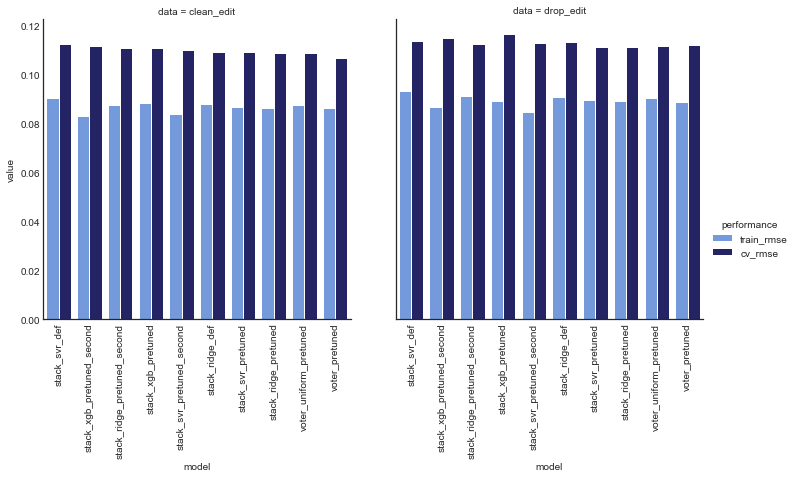

In [527]:
# compare top 10 tuned model train and cv performance on clean 
plot_model_comp(ens_comp_df.tail(10), col='data', hue='performance', 
                kind='bar', palette=data_palette)

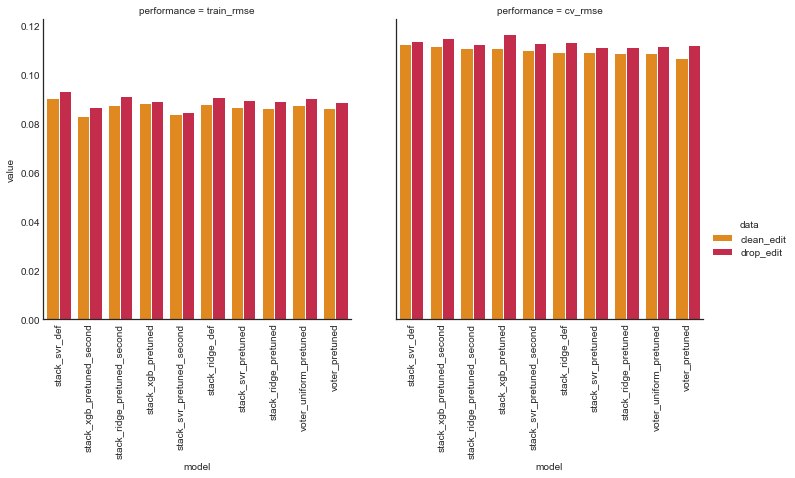

In [528]:
# compare clean and edit performance for train and cv error
plot_model_comp(ens_comp_df.tail(10), col='performance', hue='data', 
                kind='bar', palette=perf_palette)

In [529]:
# pickle tuned parameters
pickle_to_file(ensembles, '../training/ens_tuned_params.pkl')

## Predict and Evaluate

To check our test prediction performance we need to submit to Kaggle. We'll submit predictions for the top 4 ensemble models for both versions of the data (`clean_edit` and `drop_edit`) and report them here.

In [581]:
# save top 5 models from both data sets
save_top_model_predictions(ensembles=ensembles, ens_comp_df=ens_comp_df, 
               data_name='clean_edit', model_data=model_data, 
               num_models=5, save_path='../submissions')

save_top_model_predictions(ensembles=ensembles, ens_comp_df=ens_comp_df, 
               data_name='drop_edit', model_data=model_data, 
               num_models=5, save_path='../submissions')

In [594]:
# Enter results of Kaggle submissions
test_comp_df = test_comp(ens_comp_df)
test_comp_df.loc['stack_ridge_pretuned_second_drop_edit'] = 0.12615
test_comp_df.loc['voter_pretuned_drop_edit'] = 0.12310
test_comp_df.loc['voter_uniform_pretuned_drop_edit'] = 0.12356
test_comp_df.loc['stack_svr_pretuned_drop_edit'] = 0.12341
test_comp_df.loc['stack_ridge_pretuned_drop_edit'] = 0.12329
test_comp_df.loc['stack_ridge_def_clean_edit'] = 0.12417
test_comp_df.loc['stack_svr_pretuned_clean_edit'] = 0.12182
test_comp_df.loc['stack_ridge_pretuned_clean_edit'] = 0.12200
test_comp_df.loc['voter_uniform_pretuned_clean_edit'] = 0.12214
test_comp_df.loc['voter_pretuned_clean_edit'] = 0.12177
test_comp_df.sort_values(by='test_rmse')

,test_rmse
voter_pretuned_clean_edit,0.12177
stack_svr_pretuned_clean_edit,0.12182
stack_ridge_pretuned_clean_edit,0.12200
voter_uniform_pretuned_clean_edit,0.12214
voter_pretuned_drop_edit,0.12310
stack_ridge_pretuned_drop_edit,0.12329
stack_svr_pretuned_drop_edit,0.12341
voter_uniform_pretuned_drop_edit,0.12356
stack_ridge_def_clean_edit,0.12417
stack_ridge_pretuned_second_drop_edit,0.12615
